<h1><center> 
DeepLearning-Based RNA Toehold Switch Functionality Predictor Using CNNs and Complementary Maps
</center></h1>

<center>
Nicolaas M Angenent-Mari<sup>1,2*</sup>, Luis R. Soenksen<sup>1,2*</sup>, Alexander S. Garruss<sup>2,3*</sup>, Diogo M. Camacho<sup>2*</sup>, Katherine M Collins<sup>1*</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 244,000 toehold sequences to train and optimize a CNN deep-learning architecture based on RNA contact map tensors to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

References:

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-02-26_toehold_dataset.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences:
organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Input tensor is defined as (DS=Data_Style):
> **DS_1)**  Toehold DNA Sequence Complementarity Map Input Tensor <br>
> *NOTE:  Base toehold string sequence [0-144]
> *       GGG  - Trigger - Loop1 - Switch  - Loop2 - Stem1 -  AUG  -  Stem2  -  Linker - Post-linker
> *     [-3,-1]  [0,-29]  [30-49]  [50-79]  [80-90] [91,96] [97,99] [100,108] [109,134]  [135,144]
> *     
> *     For training on Off-output values. we select to start with GGG and concatenate everything from "Loop1" to "post-linker"... which is seq_SwitchOFF_GFP  = ggg + seq[30:145].
> *     Also, pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but > *     it is never in the functional toehold module), so it won't contribute in secondary structure at all. For this example > *     in particular we use DS_1.*

> #### Output is defined as:
> **OUT_1)** OFF-State vale derived from the experimental testing of toehold switch RNA sequence

#### PROBLEM DEFINITION
> To investigate if such complementarity map can be fed to a network to predict switch off-state functionality, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

### STEP 0)   Loading & Import Modules
#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste

In [1]:
## Import Libraries
# General system libraries
import os
#import cv2
import math
import h5py
import locale
import argparse
import numpy as np
import pandas as pd
from time import time

# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA
# > pysster Lib
#from pysster import utils
#from pysster.Data import Data
#from pysster.Grid_Search import Grid_Search
#from pysster.One_Hot_Encoder import One_Hot_Encoder
#from pysster.Alphabet_Encoder import Alphabet_Encoder
#RNAssp
import src.RNAssp.rna as rnassp

# Import TPOT libs
#from tpot import TPOTRegressor

# Import Tensorflow
import tensorflow as tf

# Import Json
import json

# Import Keras
from keras import optimizers
from keras import applications
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, Input, Lambda, InputLayer, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils, multi_gpu_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint
#from src.parallel.model_checkpoint_parallel import ModelCheckpoint

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc
    ## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
        # watch -n0.5 nvidia-smi
    ## NOTE: If not present, activate GPU persistence mode in terminal with
        # sudo nvidia-smi -pm 1
    ## If you do not see any GPU usage try uncommenting the following line:
        # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

# Progress Bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization mode
#%matplotlib ipympl

#Import Keras-Vis for Saliency
from vis.utils import utils
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay

# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

Using TensorFlow backend.


In [8]:
# Define path to store all generated models
model_path = 'models/Example Pretrained Models/'

# Create Data folder if not existent
if not os.path.isdir(model_path):
    os.makedirs(model_path)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available GPUs: 4


### 1) Import Dataset & Raw Inputs / Outputs
> Full data CSV read, includes all necessary information to train and test

In [5]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)

# Define path to load desired Toehold dataset file (.csv)
data_filename = data_folder + "Toehold_Dataset_Final_2019-10-23.csv"
data_path = data_filename
data = pd.read_csv(data_path)
data.head()


,Unnamed: 0,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,stem1,...,Cbn1_off,Cbn2_off,Cbn3_off,Cbn4_off,ON,OFF,ON_OFF,QC_ON,QC_OFF,QC_ON_OFF
0,0,smallpox,smallpox_tile_2626,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,AACTGTTTTCCATTTTTTTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAAAAAAATGGAAAACAGTT,AACAGAGGAGA,AACTGT,...,0.000000,1.000000,0.000000,0.0,NaN,0.333333,NaN,NaN,NaN,NaN
1,1,smallpox,smallpox_tile_2625,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TTAGTAACTGTTTTCCATTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAATGGAAAACAGTTACTAA,AACAGAGGAGA,TTAGTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,smallpox,smallpox_tile_4951,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,CTAAATTAACAATAGTAGTAATTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAATTACTACTATTGTTAATTTAG,AACAGAGGAGA,CTAAAT,...,1.000000,0.000000,0.000000,0.0,0.068295,0.000000,0.068295,3.0,2.0,2.0
3,3,smallpox,smallpox_tile_6492,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TCCAAGTAGTAGTCCTACGTTATTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAATAACGTAGGACTACTACTTGGA,AACAGAGGAGA,TCCAAG,...,0.883458,0.116542,0.000000,0.0,0.000000,0.038847,-0.038847,2.0,3.0,2.0
4,4,smallpox,smallpox_tile_2624,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACATATTAGTAACTGTTTTCCATTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAATGGAAAACAGTTACTAATATGT,AACAGAGGAGA,ACATAT,...,0.815066,0.000000,0.184934,0.0,0.080666,0.123289,-0.042624,3.0,4.0,3.0


In [6]:
### Toehold Switch dataset input/output selection for OFF ONLY
input_name = 'seq_SwitchOFF_GFP'
output_name = 'OFF'
QC='QC_OFF'

### Data filtering of missing values depending on output variable
data=data.drop(data[data[QC] <4].index,axis=0)
data=data.dropna(subset=[QC])
data.head()


,Unnamed: 0,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,stem1,...,Cbn1_off,Cbn2_off,Cbn3_off,Cbn4_off,ON,OFF,ON_OFF,QC_ON,QC_OFF,QC_ON_OFF
4,4,smallpox,smallpox_tile_2624,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACATATTAGTAACTGTTTTCCATTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAATGGAAAACAGTTACTAATATGT,AACAGAGGAGA,ACATAT,...,0.815066,0.000000,0.184934,0.000000,0.080666,0.123289,-0.042624,3.0,4.0,3.0
6,6,human_PROX1,human_PROX1_tile_176,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,ACTTGAAAAAAGCAAAGCTCATGTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAACATGAGCTTTGCTTTTTTCAAGT,AACAGAGGAGA,ACTTGA,...,0.000000,0.457525,0.542475,0.000000,0.933884,0.514158,0.419726,5.0,4.0,4.0
7,7,human_DHX9,human_DHX9_tile_195,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TAATGTTCCTGGAGCTGTGTTGGTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAACCAACACAGCTCCAGGAACATTA,AACAGAGGAGA,TAATGT,...,0.730731,0.269269,0.000000,0.000000,1.000000,0.089756,0.910244,2.0,4.0,2.0
11,11,smallpox,smallpox_tile_7220,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TGTATCAACATCGGAAAAAAATCTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAGATTTTTTTCCGATGTTGATACA,AACAGAGGAGA,TGTATC,...,0.000000,0.163688,0.836312,0.000000,0.806247,0.612104,0.194143,2.0,5.0,2.0
12,12,smallpox,smallpox_tile_29340,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,GTGAAAATATTAAAAAAAAATACTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAGTATTTTTTTTTAATATTTTCAC,AACAGAGGAGA,GTGAAA,...,0.000000,0.406794,0.592040,0.001166,0.603367,0.531457,0.071910,4.0,5.0,4.0


-----------------------------------------------------------------------------------------------------------------------------

### 2) Functions to Pre-Process Inputs / Outputs
> Define helper functions for one-hot encoding and Generation of Connectivity Map Tensors

> Definition of full input and output vectors for the network

In [5]:
# Function definition to create complementary matrix of RNA molecule from DNA
def one_hot_special_complementarity_directional_matrix(x, show=False):
    """Produce complementarity matrix for the given RNA molecule.
    by Luis Soenksen 2019-03-15
    Complementary bases (according to Watson-Crick) are assigned the following values:
    G-C are assigned 6 = [0 0 0 0 0 0 1], 
    C-G are assigned 5 = [0 0 0 0 0 1 0], 
    A-U are assigned 4 = [0 0 0 0 1 0 0],
    U-A are assigned 3 = [0 0 0 1 0 0 0],
    G-U are assigned 2 = [0 0 1 0 0 0 0], 
    U-G are assigned 1 = [0 1 0 0 0 0 0], 
    NonWCpairs are   0 = [1 0 0 0 0 0 0],

    Args:
        m: Molecule object (DNA or RNA)
        show (bool): Make a matrix plot of the result.

    Returns:
        p_oh: One-Hot Encoded Categorical Complementarity-directional Matrix
        p: Categorical(integer) Complementarity-directional Matrix
    """
    # Imports
    from keras.utils import to_categorical
    
    #Add extra padding to desired length
    while len(x) < 120:
        x=x+'N'

    if isinstance(x, str):
    # If input is string do this
        # Generate complementary matrix from sequence str & calculated dot-bracket secondary structure
        seq = Bio.Seq.transcribe(x) #Each row in the series is a toehold sequence
        l = len(seq)
        p = np.zeros((l, l), dtype='int8')
        for i in range(l):
            for j in range(l):
                if seq[i] == 'G' and seq[j] == 'C' :
                    p[i, j] = 6
                if seq[i] == 'A' and seq[j] == 'U' :
                    p[i, j] = 4  
                if seq[i] == 'G' and seq[j] == 'U' :
                    p[i, j] = 2

                # By default... if m.seq[i] == m.seq[j] ; p[i, j] = 0

                if seq[i] == 'C' and seq[j] == 'G':
                    p[i, j] = 5
                if seq[i] == 'U' and seq[j] == 'A':
                    p[i, j] = 3  
                if seq[i] == 'U' and seq[j] == 'G':
                    p[i, j] = 1

        if show:
            fig = plt.figure(dpi=300)
            ax = fig.add_subplot(111)
            cmap = plt.get_cmap('jet', np.max(p)-np.min(p)+1)
            pos = ax.matshow(p, interpolation='nearest', cmap=cmap)
            ax.set_xticks(np.arange(l))
            ax.set_yticks(np.arange(l))


            # Add colorbar to make it easy to read the energy levels
            cbar = plt.colorbar(pos, ticks=np.arange(np.min(p),np.max(p)+1))
            plt.show()                    
       
                    
    elif (isinstance(x, np.ndarray) and np.array_equal(x , x.astype(bool))):
    # If input is one-hot encoded
        m = x  
        l = len(m)
        p = np.zeros((l, l), dtype='int8')

        A = np.array([1.,0.,0.,0.])
        C = np.array([0.,1.,0.,0.])
        G = np.array([0.,0.,1.,0.])
        U = np.array([0.,0.,0.,1.]) # "T" or "U"

        for i in range(l):
            for j in range(l):
                if (np.array_equal(m[i], G) and np.array_equal(m[j], C)):
                    p[i, j] = 6
                if (np.array_equal(m[i], A) and np.array_equal(m[j], U)):
                    p[i, j] = 4  
                if (np.array_equal(m[i], G) and np.array_equal(m[j], U)):
                    p[i, j] = 2

                # By default... if m.seq[i] == m.seq[j] ; p[i, j] = 0

                if (np.array_equal(m[i], C) and np.array_equal(m[j], G)):
                    p[i, j] = 5
                if (np.array_equal(m[i], U) and np.array_equal(m[j], A)):
                    p[i, j] = 3  
                if (np.array_equal(m[i], U) and np.array_equal(m[j], G)):
                    p[i, j] = 1 
    
 
    else:
        p = np.empty([118, 118,7])
    
    p_oh = to_categorical(p[:,:]) #Convert to one hot     
    p_oh_tensor = tf.convert_to_tensor(p_oh) #Convert to one hot           
    return p_oh_tensor, p_oh, p

In [29]:
# Function to generate single complementary matrix array from linear toehold sequence
def seq2complementaryMap(x):
    _, p_oh , _ = one_hot_special_complementarity_directional_matrix(x, show=False)
    out = p_oh.astype(bool)
    return out

# Function to generate single complementary matrix array from linear toehold sequence
def seq2complementaryMap_output_shape(input_shape):
    # Generate complementary matrix from sequence str & calculated dot-bracket secondary structure
    return (tuple(input_shape[0]),tuple(input_shape[0]),tuple(7))
            
    return p

In [5]:
## INPUT / OUTPUT DEFINITION, PROCESSING & LOADING

#Init process bar
tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences
    
# Define path to store input / output arrays
tmp_data_path = 'data/tmp/'+ output_name + '/'

# Create Data folder if not existent
if not os.path.isdir(tmp_data_path):
    os.makedirs(tmp_data_path)

#INPUT VECTORS
tmp_data_input_path = (tmp_data_path + 'THdata_input_file_OFFQC4.h5')
if not os.path.exists(tmp_data_input_path):
    # Data Input selection & Generation if absent (or delete it to re-calculate)
    df_data_input = data[input_name].progress_apply(seq2complementarymap)
    data_input = np.array(list(df_data_input.values))
    #Save:
    with h5py.File(tmp_data_path + 'THdata_input_file_OFFQC4.h5', 'w') as hf:
        hf.create_dataset("input",  data=data_input)
    
#Load full input array in memory
with h5py.File(tmp_data_input_path, 'r') as hf:
    data_input = hf['input'][:] 

    
#OUTPUT VECTOR
tmp_data_output_path = (tmp_data_path + 'THdata_output_file_OFFQC4.h5')
if not os.path.exists(tmp_data_output_path):
    #Init process bar
    tqdm.pandas()
    
    # Data Output selection
    df_data_output = data[output_name]
    data_output = np.array(list(df_data_output.values), dtype=np.float32)
    
    #Save:
    with h5py.File(tmp_data_path + 'THdata_output_file_OFFQC4.h5', 'w') as hf:
        hf.create_dataset("output",  data=data_output)
    
#Load full input array in memory
with h5py.File(tmp_data_output_path, 'r') as hf:
    data_output = hf['output'][:]

#Rescale Data from -100 to 100 for Attention Visualization 
data_output=(data_output*200)-100

Distribution of Output Values


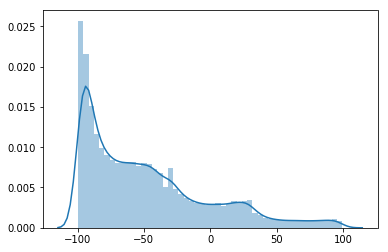

In [8]:
# Display Output Values
print('Distribution of Output Values')
sns.distplot(data_output, kde=True, rug=False)
plt.show()

-----------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------------

### 4) Evaluate network performance
> Run predictions on randomized testing set (not seen during training)

> Evaluate regression performance

> Plot Mean squared error, Mean absolute error, Mean absolute percentage error & Cosine Proximity

In [9]:
# > Save/load the entire model
from keras import backend as K

tf.reset_default_graph()
tf.keras.backend.clear_session()
K.clear_session()

model = load_model(os.path.abspath(model_path)+'/model_CNN_2DMap_OFFOnly_118ntx118nt_VIS4Map_AttentionAnalysis.h5')

In [ ]:
### Make predictions on testing data ###
### SHUFFLE TEST SET ###
TestSeed=0
(trainX, finaltestX, trainY, finaltestY) = train_test_split(data_input, data_output, test_size=0.15, random_state=TestSeed)
(trainX, testX, trainY, testY) = train_test_split(trainX, trainY, test_size=0.18, random_state=TestSeed)

print("Predicting functionality of test Toeholds...")
preds = model.predict(finaltestX)

# Testing set evaluation:
#   Compute the difference between the *predicted* toehold functionality values
#   and *actual* toehold functionality values, then compute the absolute 
#   percentage difference for diplay
diff = preds.flatten() - finaltestY
abstDiff = np.abs(diff)

# Compute the mean and standard deviation of the absolute difference:
apd_mean = np.mean(abstDiff)
apd_std = np.std(abstDiff)
print("Mean_absolute_error (TEST): " + str(apd_mean) + " (SD: " + str(apd_std) + ")" )

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

x=np.squeeze(preds)
y=finaltestY

g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=1)
g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");

In [ ]:
###
#Generate INDIVIDUAL heat maps for THE ENTIRE TEST SET
###

from keras import backend as K

#Set Grad Modifier for Keras-Vis
GradModifier='relu'

LibSize=50
pbar = tqdm(total=202*LibSize)


#File to Store Individual Attention Maps in
tmp_data_output_path = (tmp_data_path + '/AttentionMaps_RELU_CNN_OFFQC4_118ntx118nt.h5')
#Model to use for saliency maps
model = load_model(os.path.abspath(model_path)+'/model_CNN_2DMap_OFFOnly_118ntx118nt_VIS4Map_AttentionAnalysis.h5')

#Get Saliency maps for LOW signal OFF switches
for outputindex in range(0,202):
    if not os.path.exists(tmp_data_output_path):
    #Initialize empty array if no file available
        AttentionmapFile=np.zeros([10100,118,118])
    #IF A FILE IS AVAILABLE, load full input array in memory
    else:
        with h5py.File(tmp_data_output_path, 'r') as hf:
            AttentionmapFile = hf['output'][:]
            
    for index in range(0,LibSize):
    #Get AttentionMaps
        AttentionmapFile[(outputindex*LibSize)+index,:,:] = visualize_saliency(model, layer_idx=-1, filter_indices=0, seed_input=finaltestX[(outputindex*LibSize)+index], grad_modifier=GradModifier)
        pbar.update(1)
        
    #SAVE THE NEWLY UPDATED ARRAY
    with h5py.File(tmp_data_output_path, 'w') as hf:
        hf.create_dataset("output",  data=AttentionmapFile)

    #Clear session to restore memory
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    K.clear_session()
    # Load the entire model Again
    model = load_model(os.path.abspath(model_path)+'/model_CNN_2DMap_OFFOnly_118ntx118nt_VIS4Map_AttentionAnalysis.h5')
    


In [14]:
###SORT THE MOST ACCURATE ATTENTION MAPS BY OFF SIGNAL

tmp_data_output_path = (tmp_data_path + 'AttentionMaps_RELU_CNN_OFFQC4_118ntx118nt.h5')
with h5py.File(tmp_data_output_path, 'r') as hf:
    AttentionmapFile = hf['output'][:]
print(AttentionmapFile.shape)

#####
ACC_PERCENTILE=10
NUM_LEVELS=4
#####

AccurateMaps=AttentionmapFile[abstDiff<np.percentile(abstDiff,ACC_PERCENTILE)]
AccurateOFF=finaltestY[abstDiff<np.percentile(abstDiff,ACC_PERCENTILE)]

im_dpi=2000
Cutoff=np.int(len(AccurateMaps)/NUM_LEVELS)
f, ax = plt.subplots(1,NUM_LEVELS, dpi=im_dpi, figsize=(15,15))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=None)

col='black'
linwid=0.2
thresh=0.5
multiplier=4

OFFIdx=np.argsort(AccurateOFF)
AccurateMapContrast=multiplier*np.where(AccurateMaps>thresh,thresh,AccurateMaps)

print(AccurateMapContrast.shape)
print(OFFIdx.shape)

for index in range(0,NUM_LEVELS):
    i=index*Cutoff
    j=(index+1)*Cutoff
    #print(i," to ",j)
    jet_heatmap = np.uint8(cm.jet(np.mean(AccurateMapContrast[OFFIdx[i:j]],axis=0))[..., :3] * 255)
    ax[index].imshow(jet_heatmap)
    ax[index].grid(color='white',linewidth=linwid)

    
plt.setp(plt.gcf().get_axes(), xticks=[0,23,34,52,64,82,118], yticks=[0,23,34,52,64,82,118])
plt.savefig('THAttentionMapsOFF_%10MostAccurate_Quartiles.png')

(10125, 118, 118)
(1013, 118, 118)
(1013,)


In [29]:
ACC_PERCENTILE=10
Cutoff_PERCENTILE=25

AccurateMaps=AttentionmapFile[abstDiff<np.percentile(abstDiff,ACC_PERCENTILE)]
InAccurateMaps=AttentionmapFile[abstDiff>np.percentile(abstDiff,100-ACC_PERCENTILE)]
AccurateOFF=finaltestY[abstDiff<np.percentile(abstDiff,ACC_PERCENTILE)]
InAccurateOFF=finaltestY[abstDiff>np.percentile(abstDiff,100-ACC_PERCENTILE)]

im_dpi=2000
col='black'
linwid=0.2
thresh=3
multiplier=4

AccOFFIdx=np.argsort(AccurateOFF)
AccurateMapContrast=multiplier*np.where(AccurateMaps>thresh,thresh,AccurateMaps)
InAccOFFIdx=np.argsort(InAccurateOFF)
InAccurateMapContrast=multiplier*np.where(InAccurateMaps>thresh,thresh,InAccurateMaps)

AccCutoff=np.int(len(AccOFFIdx)*Cutoff_PERCENTILE/100)
InAccCutoff=np.int(len(InAccOFFIdx)*Cutoff_PERCENTILE/100)
f, ax = plt.subplots(2, 2, dpi=im_dpi*1.5)
A=0.5
col='black'
linwid=0.2

jet_heatmap = np.uint8(cm.jet(np.mean(AccurateMapContrast[AccOFFIdx[0:AccCutoff]],axis=0))[..., :3] * 255)
ax[0,0].imshow(jet_heatmap)
ax[0,0].grid(color='white',linewidth=linwid)
ax[0,0].fill_between([0,23],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([82,117],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([52,64],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([0,23],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([82,117],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([52,64],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([0,23],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([82,117],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[0,0].fill_between([52,64],[52,52],[64,64],color=col,alpha=A,linewidth=0)

jet_heatmap = np.uint8(cm.jet(np.mean(InAccurateMapContrast[InAccOFFIdx[0:InAccCutoff]],axis=0))[..., :3] * 255)
ax[0,1].imshow(jet_heatmap)
ax[0,1].grid(color='white',linewidth=linwid)
ax[0,1].fill_between([0,23],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([82,117],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([52,64],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([0,23],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([82,117],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([52,64],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([0,23],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([82,117],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[0,1].fill_between([52,64],[52,52],[64,64],color=col,alpha=A,linewidth=0)

jet_heatmap = np.uint8(cm.jet(np.mean(AccurateMapContrast[AccOFFIdx[len(AccOFFIdx)-AccCutoff:len(AccOFFIdx)]],axis=0))[..., :3] * 255)
ax[1,1].imshow(jet_heatmap)
ax[1,1].grid(color='white',linewidth=linwid)
ax[1,1].fill_between([0,23],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([82,117],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([52,64],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([0,23],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([82,117],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([52,64],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([0,23],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([82,117],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[1,1].fill_between([52,64],[52,52],[64,64],color=col,alpha=A,linewidth=0)

jet_heatmap = np.uint8(cm.jet(np.mean(InAccurateMapContrast[InAccOFFIdx[len(InAccOFFIdx)-InAccCutoff:len(InAccOFFIdx)]],axis=0))[..., :3] * 255)
ax[1,0].imshow(jet_heatmap)
ax[1,0].grid(color='white',linewidth=linwid)
ax[1,0].fill_between([0,23],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([82,117],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([52,64],[0,0],[23,23],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([0,23],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([82,117],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([52,64],[82,82],[117,117],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([0,23],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([82,117],[52,52],[64,64],color=col,alpha=A,linewidth=0)
ax[1,0].fill_between([52,64],[52,52],[64,64],color=col,alpha=A,linewidth=0)



#plt.rcParams.update({'font.size': 0.8})   
plt.rc('xtick', labelsize=0.4)    # fontsize of the tick labels
plt.rc('ytick', labelsize=0.4) 
plt.setp(plt.gcf().get_axes(), xticks=[0,23,34,52,64,82,118], yticks=[0,23,34,52,64,82,118])
plt.savefig('OFFCNNAverageSaliency_TestSetOnly_ConfusionMatrix.png')
plt.show()

-----------------------------------------------------------------------------------------------------------------------------

END OF CODE